# Modélisation des demandes de crédits avec LightGBM

## Chargement des données d'entraînement et de test

In [1]:
import sys
sys.path.insert(0, "/home/cyril/openclassrooms/projets/P7/P7_baudrillart_cyril_V2/custom_functions")

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import time
import matplotlib.pyplot as plt
from model_analysis import plot_confusion_matrix, plot_roc_curve

In [3]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [4]:
# Chargement des données intégrales imputées
X = pd.read_csv('../data_models/X_top10_imputed.csv', index_col=0)

In [5]:
X.shape

(292062, 12)

In [6]:
# Création de la target
y = X.TARGET
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
292057    1.0
292058    1.0
292059    1.0
292060    1.0
292061    1.0
Name: TARGET, Length: 292062, dtype: float64

In [7]:
# Supprimer la target des features
X = X.drop(columns='TARGET')

In [8]:
# Comptage des classes
Counter(y)

Counter({0.0: 268139, 1.0: 23923})

La classe 1 est minoritaire.

In [9]:
# train-test split with stratification on the class we are trying to predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [10]:
Counter(y_test)

Counter({0.0: 80442, 1.0: 7177})

In [11]:
Counter(y_test)[0]/Counter(y_test)[1]

11.208304305420093

In [12]:
Counter(y_train)[0]/Counter(y_train)[1]

11.208467693777619

## LightGBM

In [13]:
d_train = lgb.Dataset(X_train, label=y_train)

In [14]:
# Imputation des données manquantes et randomforest
steps = [('impute', SimpleImputer(strategy='median')),
         ('model', LGBMClassifier())]

pipeline = Pipeline(steps=steps)

In [15]:
pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('model', LGBMClassifier())])

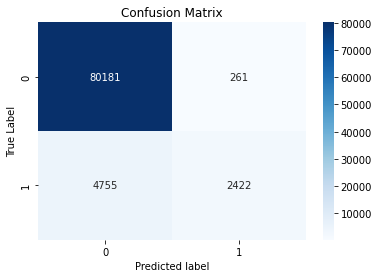

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     80442
         1.0       0.90      0.34      0.49      7177

    accuracy                           0.94     87619
   macro avg       0.92      0.67      0.73     87619
weighted avg       0.94      0.94      0.93     87619

ROC AUC Score: 0.67
CPU times: user 7.03 s, sys: 235 ms, total: 7.26 s
Wall time: 1.19 s


In [16]:
%%time
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

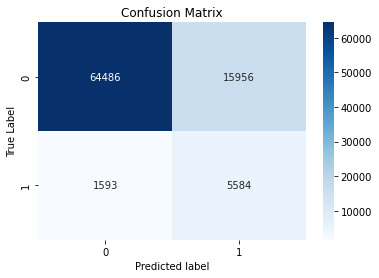

              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88     80442
         1.0       0.26      0.78      0.39      7177

    accuracy                           0.80     87619
   macro avg       0.62      0.79      0.63     87619
weighted avg       0.92      0.80      0.84     87619

ROC AUC Score: 0.79


In [17]:
# Imputation des données manquantes et randomforest
steps = [('oversample', RandomOverSampler(random_state=42)),
         ('impute', SimpleImputer(strategy='median')),
         ('model', LGBMClassifier())]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

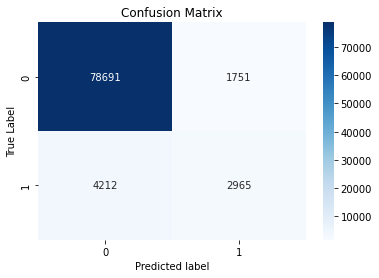

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     80442
         1.0       0.63      0.41      0.50      7177

    accuracy                           0.93     87619
   macro avg       0.79      0.70      0.73     87619
weighted avg       0.92      0.93      0.93     87619

ROC AUC Score: 0.70


In [18]:
# Imputation des données manquantes et randomforest
oversample_model = SMOTE(sampling_strategy='auto', k_neighbors=5)

steps = [('impute', SimpleImputer(strategy='median')),
         ('sampling', oversample_model),
         ('model', LGBMClassifier())]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

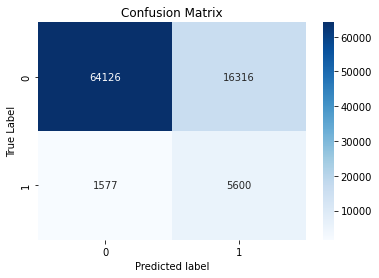

              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88     80442
         1.0       0.26      0.78      0.38      7177

    accuracy                           0.80     87619
   macro avg       0.62      0.79      0.63     87619
weighted avg       0.92      0.80      0.84     87619

ROC AUC Score: 0.79


In [19]:
# Imputation des données manquantes et randomforest
steps = [('impute', SimpleImputer(strategy='median')),
         ('model', LGBMClassifier(scale_pos_weight=11))]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

On effectue les premiers tests avec des arbres de décision qui ne nécéssitent par de standardisation des données. Afin d'obtenir des probabilités d'appartenance à chaque classe, il faut préciser la profondeur max de l'arbre (max_depth=5), autrement l'algorithme s'arrêtera quand les probabilités seront égales à 0 ou 1.

## Gridsearch LightGBM

In [24]:
# Utilisation des paramètres optimaux recommandé sur Kaggle
# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script
lgbm = LGBMClassifier(
                    n_estimators=10000,
                    learning_rate=0.02,
                    num_leaves=34,
                    colsample_bytree=0.9497036,
                    subsample=0.8715623,
                    max_depth=8,
                    reg_alpha=0.041545473,
                    reg_lambda=0.0735294,
                    min_split_gain=0.0222415,
                    verbose=-1,
                    n_jobs=-1)

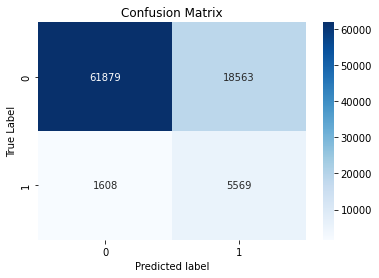

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     80442
         1.0       0.23      0.78      0.36      7177

    accuracy                           0.77     87619
   macro avg       0.60      0.77      0.61     87619
weighted avg       0.91      0.77      0.82     87619

ROC AUC Score: 0.77


In [25]:
# Imputation des données manquantes et randomforest
steps = [('sampling', RandomUnderSampler(random_state=42)),
         ('model', lgbm)]

lgbmclassifier = Pipeline(steps=steps)
lgbmclassifier.fit(X_train, y_train)
y_pred = lgbmclassifier.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

Les performances obtenues sont très proches de celles obtenues avec un XGboots optimisé (voir notebook 9) 